In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from flask import jsonify

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import inspect
from sqlalchemy.orm import Session
from sqlalchemy import Column, Integer, String, Float, create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#Create Inspector
inspector = inspect(engine)
#inspector.get_table_names()
inspector.get_columns('station')
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

# Exploratory Climate Analysis

In [81]:
def to_date(string):
    return dt.datetime.strptime(string,'%Y-%m-%d')

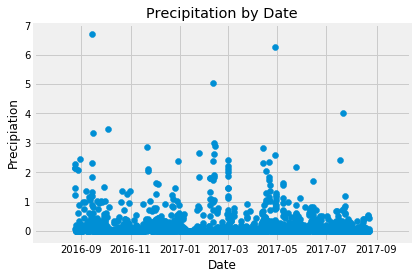

In [117]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
dates = [dt.datetime.strptime(x[0],'%Y-%m-%d') for x in session.query(Measurement.date).all()]
start_date = max(dates) - dt.timedelta(days=365)
start_date_str = dt.datetime.strftime(start_date,'%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > start_date_str).all())
prcp_df['date']=prcp_df['date'].map(to_date)
prcp_df = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
plt.scatter(prcp_df.index,prcp_df['prcp'])
plt.title('Precipitation by Date')
plt.xlabel('Date')
plt.ylabel('Precipiation')
plt.show()

In [118]:
#Compute Summary Statistics for Precipitation Data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [190]:
# Design a query to show how many stations are available in this dataset?
N_stations = session.query(func.count(Station.station)).all()[0][0]
print(f"The data were collected from {N_stations} stations.")

The data were collected from 9 stations.


In [145]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_totals = session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()



pd.DataFrame(station_totals,columns = ["Station ID","Number of Observations"])

,Station ID,Number of Observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [141]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_station = station_totals[0][0]

results = session.query(func.MAX(Measurement.tobs),func.MIN(Measurement.tobs),func.AVG(Measurement.tobs)).\
    filter(Measurement.station == max_station).all()[0]

print(f"Maximum Temperature: {results[0]}")
print(f"Minimum Temperature: {results[1]}")
print(f"Average Temperature: {results[2]}")

Maximum Temperature: 85.0
Minimum Temperature: 54.0
Average Temperature: 71.66378066378067


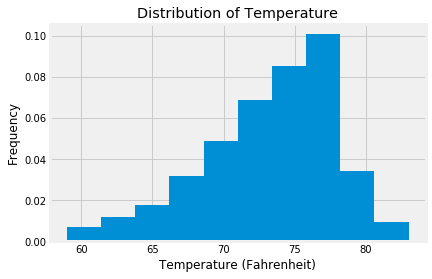

In [157]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_df = pd.DataFrame(session.query(Measurement.date,Measurement.tobs).filter(Measurement.station == max_station).\
                          filter(Measurement.date > start_date_str).all())
station_df = station_df.set_index('date')
plt.hist(station_df['tobs'],density=True)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Frequency')
plt.show()

In [163]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0]
    
    return {'Minimum':data[0],'Average':data[1],'Maximum':data[2]}
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

{'Minimum': 62.0, 'Average': 69.57142857142857, 'Maximum': 74.0}


In [191]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print("Most Recent Data for a trip from 2017-06-01 to 2017-06-08 ")
print(calc_temps('2017-06-01','2017-06-08'))

Most Recent Data for a trip from 2017-06-01 to 2017-06-08 
{'Minimum': 74.0, 'Average': 77.75, 'Maximum': 81.0}


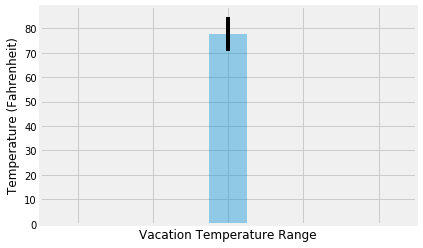

In [185]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
data = calc_temps('2017-06-01','2017-06-08')
plt.bar([1],[data['Average']],width=0.1,alpha=0.4)
plt.errorbar(1,data['Average'],yerr = data['Maximum']-data['Minimum'],color='black')
plt.xlim(.5,1.5)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.xlabel("Vacation Temperature Range")
plt.ylabel('Temperature (Fahrenheit)')
plt.show()



In [199]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
data = session.query(func.avg(Measurement.prcp),Station.id,Station.name,Station.latitude,Station.longitude,Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date <= '2017-06-08').\
    filter(Measurement.date >= '2017-06-01').\
    group_by(Station.id,Station.name,Station.latitude,Station.longitude,Station.elevation).\
    order_by(func.avg(Measurement.prcp).desc()).\
    all()

pd.DataFrame(data,columns = ['Avg Precipitation','Station ID','Station Name','Latitude','Longitude','Elevation'])



,Avg Precipitation,Station ID,Station Name,Latitude,Longitude,Elevation
0,0.141667,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.062500,2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,0.048750,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,0.043750,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,0.018750,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.002500,1,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,NaN,4,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


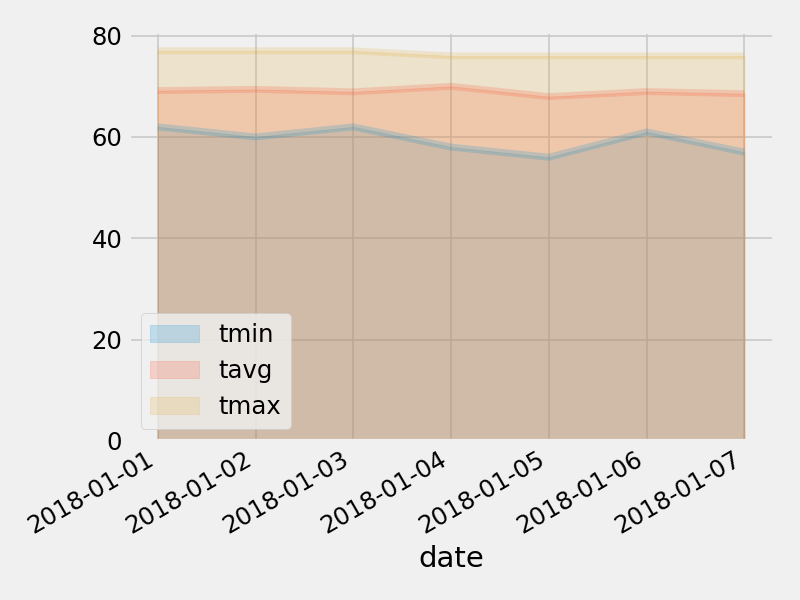

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
